In [1]:
using Plots, Random, LinearAlgebra, Statistics, SparseArrays

# Prox of nonnegative regularizer

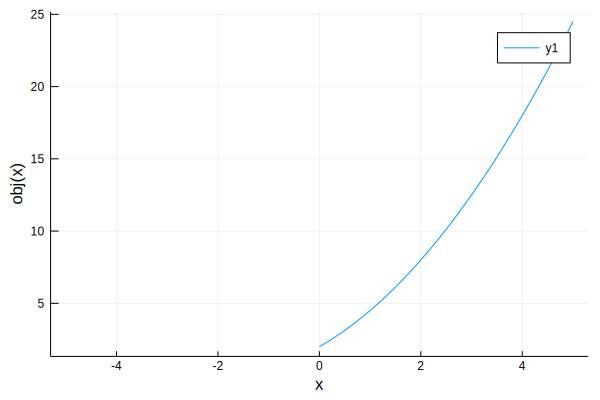

In [62]:
# prox of nonneg evaluated at z minimizes obj(x) = I(x>=0) + 1/2(x-z)^2

z = -2 # try out different values!
x = -5:.1:5
objx = [xi<0 ? Inf : 0 + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel!("x")
ylabel!("obj(x)") 

In [63]:
prox_nonneg(x) = max.(0,x)

prox_nonneg (generic function with 1 method)

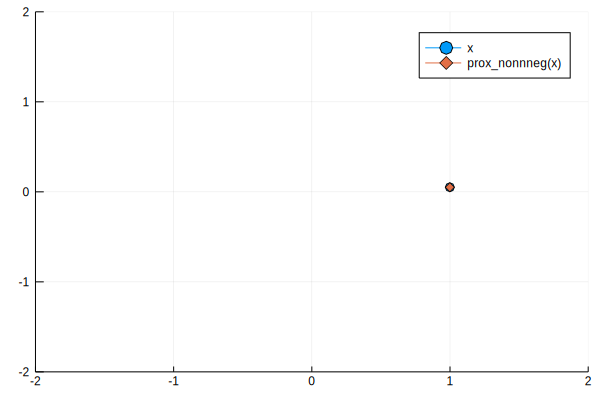

In [72]:
x = randn(2)
x /= norm(x)
px = prox_nonneg(x)

plot([x[1]],[x[2]],shape=:o,label="x")
plot!([px[1]],[px[2]],shape=:d,label="prox_nonnneg(x)")
xlims!((-2,2))
ylims!((-2,2))

# Prox of l1 regularizer

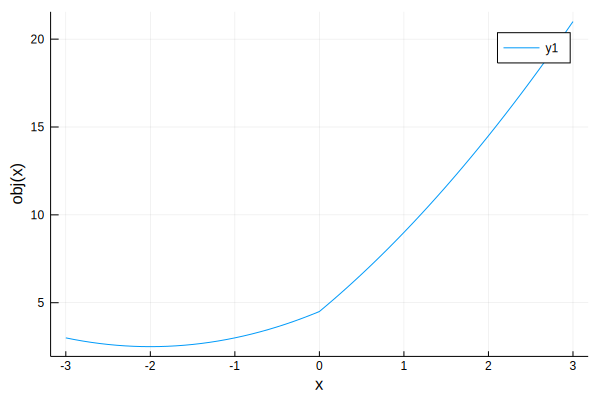

In [78]:
# prox of l1 evaluated at z minimizes |x| + 1/2(x-z)^2
z = -3
x = -3:.1:3
objx = [abs(xi) + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel!("x")
ylabel!("obj(x)")

In [79]:
function prox_l1(x::Number, alpha=1)
    if x > alpha
        return x-alpha
    elseif x < -alpha
        return x + alpha
    else
        return 0
    end
end

prox_l1 (generic function with 2 methods)

In [88]:
@show x = randn()
@show px = prox_l1(x);

x = randn() = 1.5029305285375683
px = prox_l1(x) = 0.5029305285375683


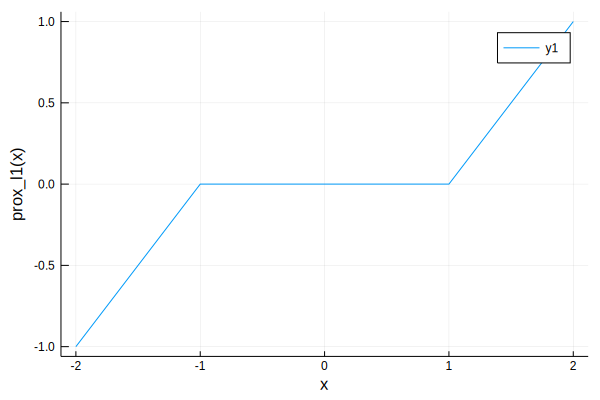

In [90]:
x = -2:.1:2
px = [prox_l1(xi) for xi in x]
plot(x, px)
xlabel!("x")
ylabel!("prox_l1(x)")

In [95]:
@show x = randn(2)
@show px = prox_l1.(x);

x = randn(2) = [0.11303552863623754, -1.40588387554246]
px = prox_l1.(x) = Real[0, -0.4058838755424601]


# proximal gradient method

$$\nabla \|Xw-y\|^2 = \nabla((Xw-y)^T (Xw-y)) = 2X^T(Xw-y)$$

In [10]:
# proximal gradient method for quadratic loss and nonnegative regularizer
function proxgrad_quad_nonneg(X, y; maxiters = 10, stepsize = 1, w = zeros(size(X,2)))
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        z = w - stepsize*g
        # prox step
        w = prox_nonneg(z)
        # record objective value
        push!(objval, norm(X*w-y)^2 + any(w<0) ? Inf : 0)
    end
    return w, objval
end

proxgrad_quad_nonneg (generic function with 1 method)

In [11]:
# proximal gradient method for quadratic loss and l1 regularizer
function proxgrad_quad_l1(X, y; maxiters = 10, stepsize = 1., λ = 1., w = zeros(size(X,2)))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        z = w - stepsize*g
        # prox step
        myprox(z) = prox_l1(z, stepsize*λ)
        w = myprox.(z)
        # record objective value
        push!(objval, norm(X*w-y)^2 + norm(w,1))
    end
    return w, objval
end

proxgrad_quad_l1 (generic function with 1 method)

let's solve the problem $$\text{minimize} \quad (y-w)^2 + |w|$$

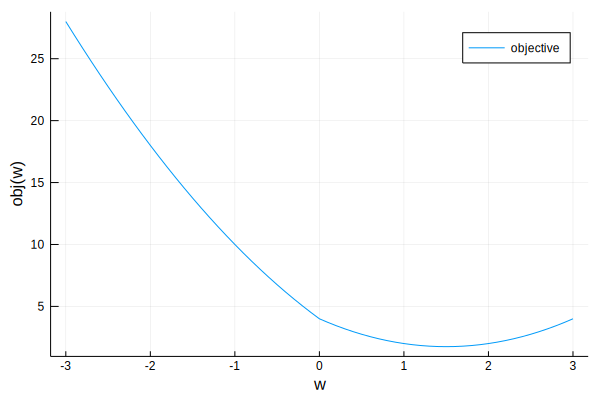

In [96]:
y = 2
wvec = -3:.1:3
objwvec = [(wi-y)^2 + abs(wi) for wi in wvec]
plot(wvec, objwvec, label="objective")
xlabel!("w")
ylabel!("obj(w)")

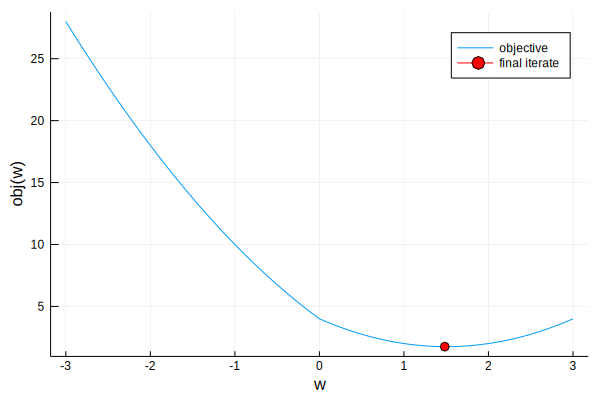

In [105]:
w = [-2]
X, y = ones(1,1), 2*ones(1)
w, obj = proxgrad_quad_l1(X, y; maxiters = 10, stepsize = .2, w = w)

plot(wvec, objwvec, label="objective")
xlabel!("w")
ylabel!("obj(w)")
plot!([w], [obj[end]], color=:red, shape=:o, label="final iterate")

In [106]:
obj

10-element Array{Float64,1}:
 5.039999999999999 
 2.7904            
 2.1245439999999998
 1.8848358399999998
 1.7985409024      
 1.767474724864    
 1.75629090095104  
 1.7522647243423743
 1.7508153007632548
 1.7502935082747717

# Introduce LowRankModels

In [107]:
using LowRankModels

In [108]:
# loss function
loss = QuadLoss()

QuadLoss(1.0, RealDomain())

In [109]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

QuadReg(1.0)

In [110]:
# the quad loss returns the sum of square differences between its first and second argument
evaluate(loss, 2., 3.)

1.0

In [111]:
evaluate(3*loss, 2., 3.)

3.0

In [112]:
evaluate(1/2*loss, [2., 2.], [3., 3.])

1.0

In [113]:
# can also evaluate the gradient wrt the first argument
grad(loss, 2., 0.)

4.0

In [114]:
grad(loss, 0., 2.)

-4.0

In [115]:
grad(L1Loss(), 2., 0.)

1.0

In [117]:
# can evaluate the proximal operator of the regularizer
prox(nonneg, [-1, 1])

2-element Array{Int64,1}:
 0
 1

In [118]:
# can evaluate the proximal operator of lambda times the regularizer
λ = .01
prox(l1, 1, λ)

0.99

In [26]:
# chain rule: 
# gradient of ||Xw - y||^2 wrt w is X' * <gradient of ||z-y||^2 wrt z>, 
# where z = X*w

In [27]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 19 methods)

In [119]:
# proximal gradient method
function proxgrad(loss, reg, X, y; maxiters = 10, stepsize = 1)
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = grad(loss, X, w, y)
        z = w - stepsize*g
        # prox step
        w = prox(reg, z, stepsize)
        # record objective value
        push!(objval, evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w, objval
end

proxgrad (generic function with 2 methods)

In [120]:
# proximal gradient method
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 2 methods)

In [121]:
Random.seed!(0)
X, y = rand(6,3), rand(6);

ch.objective = [2.432031123844957, 2.400586779251979, 2.3696896508736267, 2.3393298976806642, 2.309497857069546, 2.280184041621006, 2.251379135917557, 2.223073993418834, 2.195259633393735, 2.1679272379083083, 2.141068148868403, 2.1146738651160546, 2.0887360395786527, 2.063246476469923, 2.038197128541778, 2.013580094386117, 1.989387615785667, 1.9656120751129753, 1.9422459927766649, 1.9192820247141154, 1.8967129599297068, 1.8745317180778098, 1.8527313470896998, 1.8313050208436064, 1.8102460368771036, 1.789547814141082, 1.7692038907945369, 1.749207922039437, 1.7295536779949434, 1.7102350416102619, 1.6912460066154313, 1.6725806755093502, 1.6542332575843717, 1.6361980669868021, 1.6184695208126436, 1.6010421372379493, 1.5839105336831538, 1.5670694250107675, 1.5505136217558255, 1.5342380283884947, 1.518237641608256, 1.5025075486690915, 1.487042925735101, 1.4718390362660125, 1.4568912294320253, 1.4421949385574662, 1.4277456795927268, 1.4135390496139735, 1.3995707253501202, 1.3858364617365704]


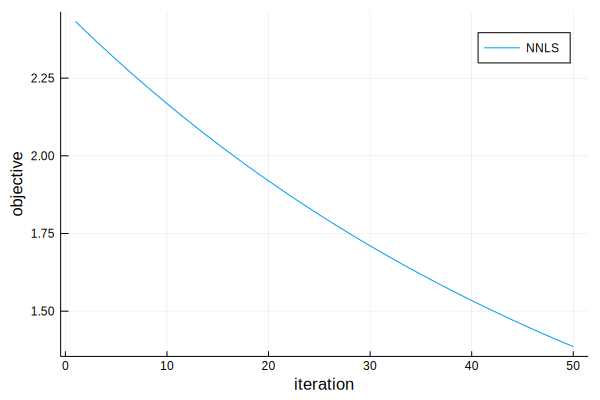

In [129]:
ch = ConvergenceHistory("NNLS")
w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; 
             stepsize=.001, maxiters=50,
             ch = ch)

@show ch.objective
plot(ch.objective, label="NNLS")
xlabel!("iteration")
ylabel!("objective")

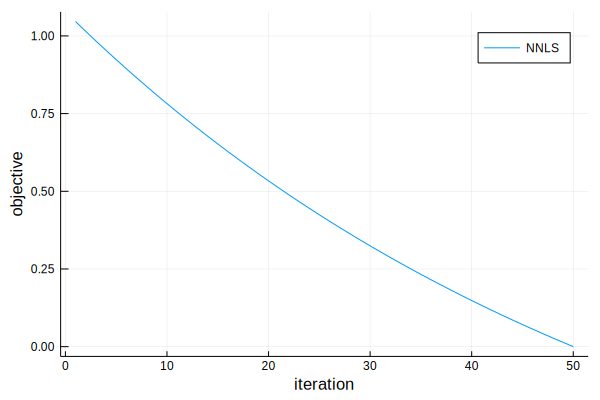

In [130]:
plot(ch.objective .- ch.objective[end], label="NNLS") # try semilog
xlabel!("iteration")
ylabel!("objective")

# Let's generate some more data and test out these models

In [33]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# let's repeat what we did in the regularized regression notebook, using our nifty proximal gradient method

compare different kinds of regularized regression

In [34]:
function ridge_regression(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*QuadReg(), X, y; kwargs...)
    return w
end

ridge_regression (generic function with 1 method)

In [35]:
function nnls(X,y; kwargs...)
    w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; kwargs...)
    return w
end

nnls (generic function with 1 method)

In [36]:
function lasso(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*OneReg(), X, y; kwargs...)
    return w
end

lasso (generic function with 1 method)

In [37]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

w = w_sparse

X, y = generate_noisy_data(30, w)

([-2.0621649242798017 -1.0436101155270108 … 2.510004785020815 0.4930136158558041; 0.24694222417539544 -1.67939406061575 … -1.7060348808645165 0.1522785487105081; … ; -0.447924030179972 -2.1110173410586723 … -0.6287731467693565 1.0654492526521435; 0.3625307235229423 1.2193347515820447 … 0.20861224419481925 1.1191460910605757], [-8.7356379598709, 3.1131542854157117, -0.899828645296596, 3.820932687128316, 9.816935143327793, 0.8521293976992345, 6.911893225379111, -2.8786226431273336, -1.6580150275959167, 4.920510074858072  …  -3.461630695081858, -7.690401159531422, -4.896995826401644, -2.0841499632575986, -4.787546503915846, -4.68290862062669, 6.210395483674711, -4.198984647292979, 3.2955407060312076, 7.335249896277118])

In [38]:
maxiters = 10000
stepsize = .1/norm(X)

w_ridge = ridge_regression(X,y, maxiters=maxiters, stepsize=stepsize)
w_nonneg = nnls(X,y, maxiters=maxiters, stepsize=stepsize)
w_lasso = lasso(X,y, maxiters=maxiters, stepsize=stepsize);

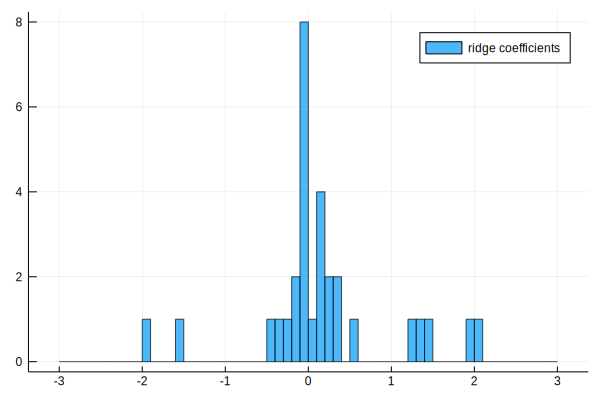

In [39]:
histogram(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

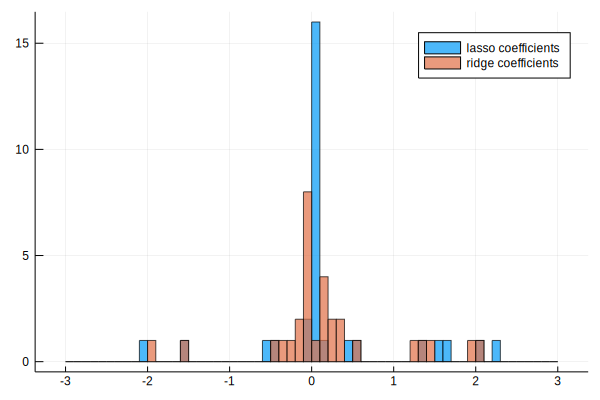

In [40]:
histogram(w_lasso, label="lasso coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

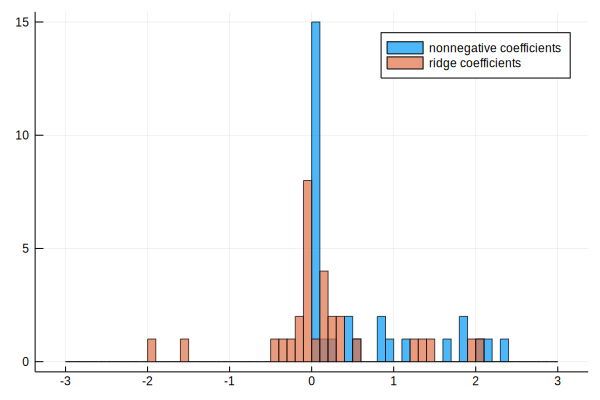

In [41]:
histogram(w_nonneg, label="nonnegative coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

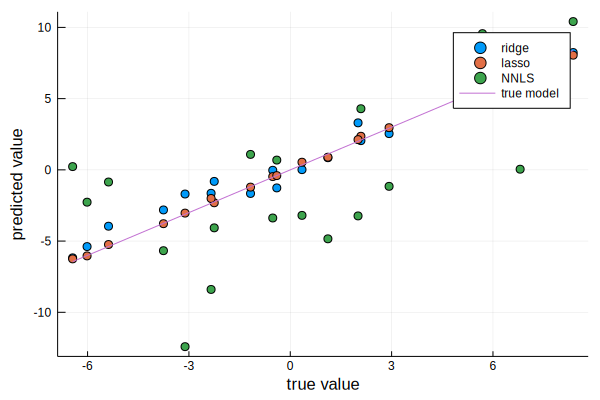

In [42]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

scatter(ytest,Xtest*w_ridge,label="ridge")
scatter!(ytest,Xtest*w_lasso,label="lasso")
scatter!(ytest,Xtest*w_nonneg,label="NNLS")
plot!(ytest,ytest,label="true model")
xlabel!("true value")
ylabel!("predicted value")

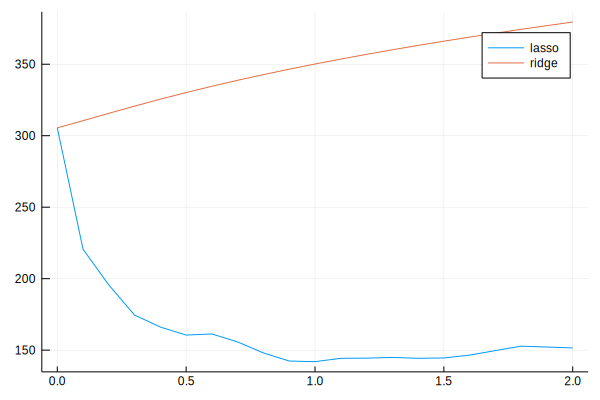

In [43]:
# cross validate over lambda
Random.seed!(1)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

maxiters = 10000
stepsize = .1/norm(X)

ridge_error = Float64[]
lasso_error = Float64[]
λs = 0:.1:2
for λ in λs
    w = ridge_regression(X,y, λ=λ, maxiters=maxiters, stepsize=stepsize)
    push!(ridge_error, sum((ytest - Xtest*w).^2))
    w = lasso(X,y, λ=λ, maxiters=maxiters, stepsize=stepsize);
    push!(lasso_error, sum((ytest - Xtest*w).^2))
end
plot(λs, lasso_error, label="lasso")
plot!(λs, ridge_error, label="ridge")